In [1]:
import copy 
import time
import pickle 
import warnings
import scipy
import scipy.sparse
import scipy.sparse.linalg
from collections import defaultdict, OrderedDict

from numpy import matrix, asmatrix
from scipy.sparse.sputils import asmatrix

import torch
import random
import numpy as np
import fastmat as fm  # need 0.2a3 or later?

import matplotlib.gridspec as gridspec
warnings.filterwarnings("ignore")
from pylab import rcParams
from matplotlib import container
from matplotlib import pyplot as plt
from IPython.core.display import  HTML
from matplotlib import cm # Colormaps

import os, sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.environ['PRJ'] = "~/skisg/"
sys.path.append(os.environ['PRJ'])

random.seed(1337)
np.random.seed(1337)

%load_ext autoreload
%autoreload 2

/var/folders/gj/ns_zjdqx57b1mrqf3l8_rcd40000gp/T/ipykernel_98474/967003846.py:11: DeprecationWarning: Please use `asmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.sputils` namespace is deprecated.
  from scipy.sparse.sputils import asmatrix


In [2]:
import gpytorch as gp

from skisg.interp.sparse.sglocations import get_sg_points_nd, help_get_sg_points_nd
from skisg.interp.sparse.sgindices import lexorder_matrix, compute_LI, compute_levels
from skisg.interp.sparse.construct import sparse_grid_size_table

from skisg.config import SgBasisType, InterpType, SobolevKernType

from skisg.interp.sginterp import SparseInterpolation

import skisg.utils as utils

from skisg.interp.sparse.weights import compute_W
import skisg.config as config

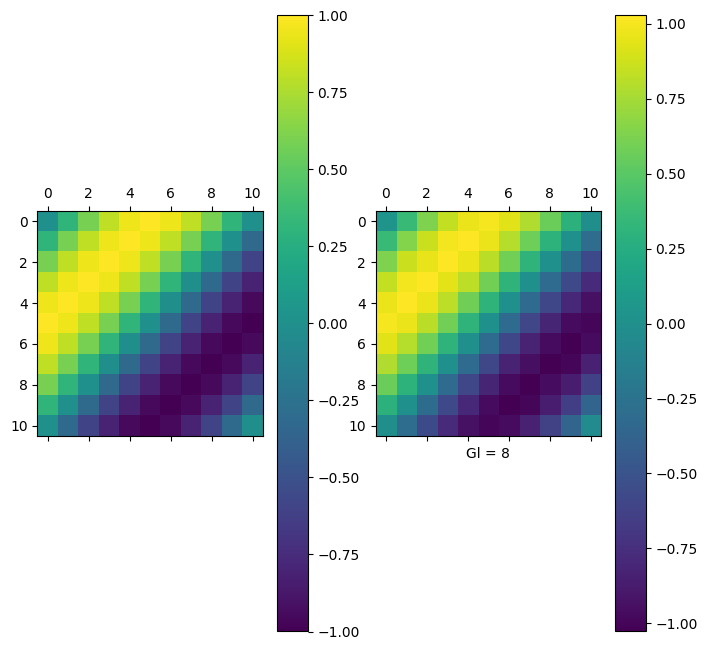

GL 8 MSE: 0.017134607886408484 0.626157201421013


In [4]:
from skisg.interp.sparse.nbhors import compute_B, compute_comb_B_diag
from gpytorch.lazy import MatmulLazyTensor

ndim = 2
npoints = 160 + 1

on_sparse_grid = False

basis = SgBasisType.MODIFIED
interp_type = InterpType.SIMPLEX #CUBIC

comb = True
ndimpoints = 11
epsilon = 10**(-7)
x1s = np.linspace(0 + epsilon, 1 - epsilon, num=ndimpoints)
x2s = np.linspace(0 + epsilon, 1 - epsilon, num=ndimpoints)
x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
X = np.vstack([x1.ravel(), x2.ravel()]).T
npoints = X.shape[0]
func = lambda x:  np.sin(np.pi*(x[:, 0] + x[:, 1]))

# for gl in [8]:

gl = 8
order = compute_LI(gl, ndim, basis=basis, comb=comb, rmat=False)
sg_locs = get_sg_points_nd(gl, ndim, basis, comb=comb, umin=0, umax=1, ordered=False)
sg_locs = sg_locs[order, :]

if on_sparse_grid:
    X = torch.from_numpy(sg_locs)
else:
    X = torch.from_numpy(X)

f_sg = torch.from_numpy(func(sg_locs)).reshape(-1, 1) #.to(torch.float32)
# W = compute_W(X, gl, ndim, umin=0.0, umax=1.0, dtype=torch.float32, 
#               use_torch=True, comb=comb, interp_type=interp_type, basis=basis)   
Phi = SparseInterpolation().sparse_interpolate(
        grid_level=gl,
        ndim=ndim, umin=0.0, umax=1.0,
        x_target = X,
        comb=comb,
        interp_type=interp_type,
        basis=basis
)

B = compute_comb_B_diag(gl, ndim, basis=basis, device=X.device, dtype=X.dtype)
W = MatmulLazyTensor(Phi, B)
    
f_h = W.matmul(f_sg).detach().numpy().reshape(-1)

if not on_sparse_grid:
    figsize=(8, 8)
    vmin=-10
    vmax=12
    fig, axs = plt.subplots(1, 2, figsize=figsize)    
    aax = axs[0].matshow(func(X).reshape(ndimpoints, ndimpoints)) #,vmin=-1, vmax=1)
    fig.colorbar(aax, ax=axs[0])
    aax = axs[1].matshow(f_h.reshape(ndimpoints, ndimpoints)) #, vmin=-1, vmax=1)
    fig.colorbar(aax, ax=axs[1])
    plt.xlabel('Gl = ' + str(gl))
    plt.show()
print("GL", gl, "MSE:", np.mean(np.abs(func(X).numpy() - f_h)), np.mean(np.abs(func(X).numpy())))

In [5]:
## Testing interpolation for 2-D sine function 
def plots_results(comb=False, interp_type=InterpType.LINEAR, basis=SgBasisType.NAIVE):
    ndim = 2
    npoints = 160 + 1

    ndimpoints = 11
    epsilon = 10**(-7)
    x1s = np.linspace(0 + epsilon, 1 - epsilon, num=ndimpoints)
    x2s = np.linspace(0 + epsilon, 1 - epsilon, num=ndimpoints)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    X = np.vstack([x1.ravel(), x2.ravel()]).T
    npoints = X.shape[0]
    func = lambda x: np.sin(4*np.pi*(x[:, 0] + x[:, 1]))

    X = torch.from_numpy(X)
    
    for gl in range(5, 10, 2):

        order = compute_LI(gl, ndim, basis=basis, comb=comb, rmat=False)
        sg_locs = get_sg_points_nd(gl, ndim, basis, comb=comb, umin=-0.2, umax=1.2, ordered=False)
        sg_locs = sg_locs[order, :]
        f_sg = torch.from_numpy(func(sg_locs)).reshape(-1, 1).to(torch.float32)
        
        Phi = SparseInterpolation().sparse_interpolate(
        grid_level=gl,
        ndim=ndim, umin=-0.2, umax=1.2,
        x_target = X,
        comb=comb,
        interp_type=interp_type,
        basis=basis
        )

        B = compute_comb_B_diag(gl, ndim, basis=basis, device=X.device, dtype=X.dtype)
        W = MatmulLazyTensor(Phi, B)

        # W = compute_W(torch.from_numpy(X), gl, ndim, umin=-0.2, umax=1.2, dtype=torch.float32, 
        #               use_torch=True, comb=comb, interp_type=interp_type, basis=basis)            
        f_h = W.matmul(f_sg).detach().numpy()
    
        print("GL", gl, "MSE:", np.mean(np.abs(f_h.squeeze() - func(X).numpy())), 
              "Func energy: ", np.mean(np.abs(func(X).numpy())))


# Combination interpolation 
for interp_type in [InterpType.LINEAR, InterpType.CUBIC, InterpType.SIMPLEX]:
    for basis in [SgBasisType.MODIFIED]: #, SgBasisType.BOUNDSTART]:

        print("\n\n",interp_type, basis)
        plots_results(comb=True, interp_type=interp_type, basis=basis)



 InterpType.LINEAR SgBasisType.MODIFIED
GL 5 MSE: 0.5548153261925668 Func energy:  0.6104497943554834
GL 7 MSE: 0.1437170865379411 Func energy:  0.6104497943554834
GL 9 MSE: 0.017104308545588025 Func energy:  0.6104497943554834


 InterpType.CUBIC SgBasisType.MODIFIED
GL 5 MSE: 0.6855016187041785 Func energy:  0.6104497943554834
GL 7 MSE: 0.04948512743105769 Func energy:  0.6104497943554834
GL 9 MSE: 0.0008067773140260803 Func energy:  0.6104497943554834


 InterpType.SIMPLEX SgBasisType.MODIFIED
GL 5 MSE: 0.7975096242602145 Func energy:  0.6104497943554834
GL 7 MSE: 0.3141527459399511 Func energy:  0.6104497943554834
GL 9 MSE: 0.13437957173957507 Func energy:  0.6104497943554834
